In [3]:
# ------------------------------------------------------------------------------ #
# @Author:        F. Paul Spitzner
# @Email:         paul.spitzner@ds.mpg.de
# @Created:       2023-08-01 11:17:08
# @Last Modified: 2023-08-15 16:03:56
# ------------------------------------------------------------------------------ #
# just a scrap book for quick and dirty exploration
# PS 23-10-09: moved everything crucial into a suitable place.
# ------------------------------------------------------------------------------ #

%reload_ext autoreload
%autoreload 2
%reload_ext ipy_dict_hierarchy
%reload_ext watermark

import logging
logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

import re
import glob
import h5py
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import dask

from tqdm import tqdm


# also needs to be added for each dask-worker
extra_path = os.path.abspath('../')
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

data_dir = "../../../gnode/experiment_analysis/dat/"


2023-08-29 16:17:04,009 | INFO     | notebook | <module> | project directory: /Users/paul/para/2_Projects/information_timescales/repo/_latest/experiment_analysis


In [50]:
data_dir = "../../../gnode/experiment_analysis/dat/"
meta_df = utl.all_unit_metadata(data_dir, reload=False)
meta_df = utl.load_spikes(meta_df, format="numpy")
meta_df = utl.default_filter(meta_df, trim=False)  # only updates the status column
meta_df["spiketimes"] = meta_df.apply(
    lambda row: utl.prepare_spike_times(row["spiketimes"], row["stimulus"]),
    axis=1,
)

meta_df.tail()

Loading spikes for sessions: 100%|██████████| 58/58 [00:38<00:00,  1.51it/s]
2023-08-28 16:59:12,230 | WARNING  | its_utility | default_filter | 278 rows already have values other than `SUCCESS` in the `invalid_spiketimes_check`. We overwrite them.


,session,stimulus,block,unit_id,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,spiketimes
31185,821695405,spontaneous,null,951109353,VISal,SUCCESS,1802.059082,4.322832,/Users/paul/para/2_Projects/information_timesc...,7790,"[1.0673828, 1.2216797, 1.4301758, 1.4970703, 1..."
31186,821695405,spontaneous,null,951110024,VISal,SUCCESS,1802.356445,1.460311,/Users/paul/para/2_Projects/information_timesc...,2632,"[0.6040039, 1.4423828, 1.7998047, 1.8193359, 2..."
31187,821695405,spontaneous,null,951109432,VISal,SUCCESS,1801.380371,4.220653,/Users/paul/para/2_Projects/information_timesc...,7603,"[0.34960938, 1.9584961, 2.616211, 2.6401367, 2..."
31188,821695405,spontaneous,null,951109459,VISal,SUCCESS,1699.346191,0.102981,/Users/paul/para/2_Projects/information_timesc...,175,"[28.614258, 35.16211, 50.05127, 50.06543, 51.2..."
31189,821695405,spontaneous,null,951109675,VISal,SUCCESS,1797.490723,1.110437,/Users/paul/para/2_Projects/information_timesc...,1996,"[0.4501953, 0.6958008, 0.8120117, 0.89453125, ..."


In [48]:
meta_df = utl.default_filter(meta_df, trim=False)  # only updates the status column
meta_df["spiketimes"] = meta_df.apply(
    lambda row: utl.prepare_spike_times(row["spiketimes"], row["stimulus"]),
    axis=1,
)

meta_df.tail()

[1.4160156e-01 1.7285156e-01 1.9677734e-01 ... 8.3986597e+02 8.3993311e+02
 8.3994580e+02]


,session,stimulus,block,unit_id,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,spiketimes
0,787025148,natural_movie_one_more_repeats,3.0,951013153,VISam,SUCCESS,900.668701,21.542880,/Users/paul/para/2_Projects/information_timesc...,19403,"[2297.1938, 2297.2266, 2297.2595, 2297.2847, 2..."
1,787025148,natural_movie_one_more_repeats,3.0,951013143,VISam,SUCCESS,900.718262,11.652925,/Users/paul/para/2_Projects/information_timesc...,10496,"[2297.2188, 2297.2615, 2297.2722, 2297.3352, 2..."
2,787025148,natural_movie_one_more_repeats,3.0,951013133,VISam,SUCCESS,894.867676,0.448111,/Users/paul/para/2_Projects/information_timesc...,401,"[2301.4895, 2304.6262, 2318.3127, 2318.4626, 2..."
3,787025148,natural_movie_one_more_repeats,3.0,951013202,VISam,SUCCESS,900.264893,2.384853,/Users/paul/para/2_Projects/information_timesc...,2147,"[2297.3667, 2297.4749, 2297.5432, 2297.5715, 2..."
4,787025148,natural_movie_one_more_repeats,3.0,951013187,VISam,SUCCESS,896.074707,0.706414,/Users/paul/para/2_Projects/information_timesc...,633,"[2299.9456, 2299.9705, 2300.328, 2300.6438, 23..."
...,...,...,...,...,...,...,...,...,...,...,...
31185,821695405,spontaneous,null,951109353,VISal,SUCCESS,1802.059082,4.322832,/Users/paul/para/2_Projects/information_timesc...,7790,"[4394.321, 4394.8145, 4394.945, 4395.0215, 439..."
31186,821695405,spontaneous,null,951110024,VISal,SUCCESS,1802.356445,1.460311,/Users/paul/para/2_Projects/information_timesc...,2632,"[4394.0005, 4394.791, 4395.0347, 4395.234, 439..."
31187,821695405,spontaneous,null,951109432,VISal,SUCCESS,1801.380371,4.220653,/Users/paul/para/2_Projects/information_timesc...,7603,"[4394.1562, 4394.2617, 4394.8813, 4395.3687, 4..."
31188,821695405,spontaneous,null,951109459,VISal,SUCCESS,1699.346191,0.102981,/Users/paul/para/2_Projects/information_timesc...,175,"[4478.77, 4500.9507, 4501.108, 4523.8774, 4567..."


In [29]:
spikes = np.array([1,2,3])
spikes[0:0]

array([], dtype=int64)

In [25]:
meta_df = utl.default_filter(meta_df, trim=False)

2023-08-28 15:33:56,498 | WARNING  | its_utility | default_filter | 851 rows already have values other than `SUCCESS` in the `invalid_spiketimes_check`. We overwrite them.


In [ ]:
for index, df in meta_df.groupby(["stimulus", "block"]):
    duration = df["recording_length"].median()
    print(f"{index}: {len(df)} rows, median duration: {duration:.2f}")

('natural_movie_one_more_repeats', '3.0'): 6022 rows, median duration: 899.97
('natural_movie_one_more_repeats', '8.0'): 6022 rows, median duration: 900.17
('natural_movie_three', '3.0'): 6562 rows, median duration: 599.80
('natural_movie_three', '6.0'): 6562 rows, median duration: 599.97
('spontaneous', 'null'): 6022 rows, median duration: 1801.61


(500.0, 600.0)

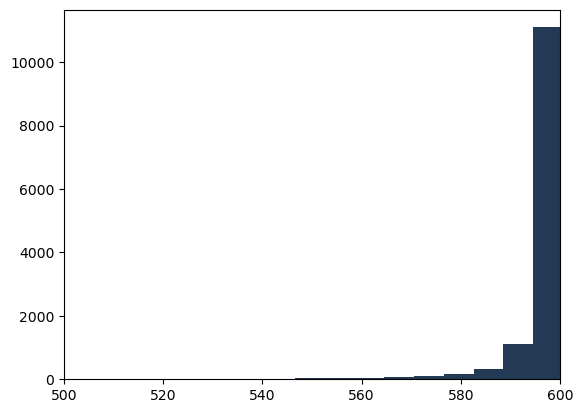

In [9]:
fig, ax = plt.subplots()
ax.hist(meta_df.query("stimulus == 'natural_movie_three'")["recording_length"], bins=100);
ax.set_xlim(500, 600)

In [45]:
# convert all spiketimes from xarray to numpy
meta_df["spiketimes"] = meta_df["spiketimes"].apply(lambda x: x.values.squeeze().flatten())

In [46]:
meta_df.to_feather("/Users/paul/Desktop/meta_df.feather")

In [12]:
foo = pd.read_feather("/Users/paul/Desktop/meta_df.feather")
foo

,session,stimulus,block,unit_id,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,spiketimes
0,787025148,natural_movie_one_more_repeats,3.0,951013153,VISam,SUCCESS,900.668806,21.542880,/Users/paul/para/2_Projects/information_timesc...,19403,"[2297.1938, 2297.2266, 2297.2595, 2297.2847, 2..."
1,787025148,natural_movie_one_more_repeats,3.0,951013143,VISam,SUCCESS,900.718039,11.652925,/Users/paul/para/2_Projects/information_timesc...,10496,"[2297.2188, 2297.2615, 2297.2722, 2297.3352, 2..."
2,787025148,natural_movie_one_more_repeats,3.0,951013133,VISam,SUCCESS,894.867666,0.448111,/Users/paul/para/2_Projects/information_timesc...,401,"[2301.4895, 2304.6262, 2318.3127, 2318.4626, 2..."
3,787025148,natural_movie_one_more_repeats,3.0,951013202,VISam,SUCCESS,900.265072,2.384853,/Users/paul/para/2_Projects/information_timesc...,2147,"[2297.3667, 2297.4749, 2297.5432, 2297.5715, 2..."
4,787025148,natural_movie_one_more_repeats,3.0,951013187,VISam,SUCCESS,896.074534,0.706414,/Users/paul/para/2_Projects/information_timesc...,633,"[2299.9456, 2299.9705, 2300.328, 2300.6438, 23..."
...,...,...,...,...,...,...,...,...,...,...,...
31185,821695405,spontaneous,null,951109353,VISal,SUCCESS,1802.059343,4.322832,/Users/paul/para/2_Projects/information_timesc...,7790,"[4394.321, 4394.8145, 4394.945, 4395.0215, 439..."
31186,821695405,spontaneous,null,951110024,VISal,SUCCESS,1802.356277,1.460311,/Users/paul/para/2_Projects/information_timesc...,2632,"[4394.0005, 4394.791, 4395.0347, 4395.234, 439..."
31187,821695405,spontaneous,null,951109432,VISal,SUCCESS,1801.380210,4.220653,/Users/paul/para/2_Projects/information_timesc...,7603,"[4394.1562, 4394.2617, 4394.8813, 4395.3687, 4..."
31188,821695405,spontaneous,null,951109459,VISal,SUCCESS,1699.346106,0.102981,/Users/paul/para/2_Projects/information_timesc...,175,"[4478.77, 4500.9507, 4501.108, 4523.8774, 4567..."


# Analysis after cutting blocks

In [4]:
b3_df = pd.read_hdf(f"{data_dir}/all_units_no_merging_block_3_spont_final.h5", key="meta_df")
b3_df.set_index(['unit_id', 'stimulus', 'session', 'block'], inplace=True)
b6_df = pd.read_hdf(f"{data_dir}/all_units_no_merging_block_6_8_final.h5", key="meta_df")
b6_df.set_index(['unit_id', 'stimulus', 'session', 'block'], inplace=True)

In [5]:
meta_df = pd.concat([b3_df, b6_df], axis=0)
meta_df.to_hdf(f"{data_dir}/all_units_no_merging_all.h5", key="meta_df")

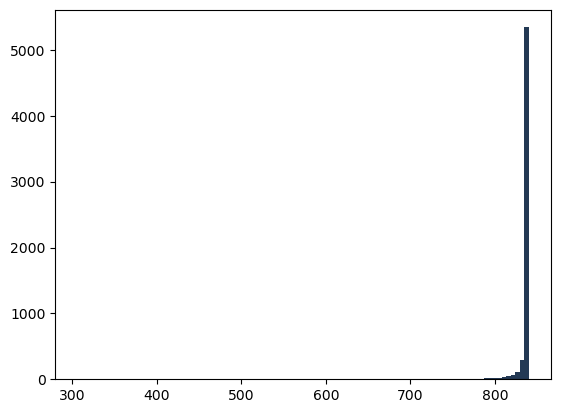

In [12]:
fig, ax = plt.subplots()
last_spikes = []
for i in meta_df.query("stimulus == 'spontaneous'").iterrows():
    last_spikes.append(i[1]["spiketimes"][-1])
ax.hist(last_spikes, bins=100);
# ax.set_xlim(800, 910)

In [6]:
utl.log.setLevel("DEBUG")
meta_df = utl.load_metrics(meta_df.reset_index(), data_dir)
meta_df

2023-08-29 16:17:11,441 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'g_dsi_dg', 'mod_idx_dg', 'image_selectivity_ns'] from /Users/paul/para/2_Projects/information_timescales/repo/gnode/experiment_analysis/dat/brain_observatory_unit_metrics_filtered.csv
2023-08-29 16:17:11,442 | DEBUG    | its_utility | load_metrics | Matched 12807 rows from meta_df in /Users/paul/para/2_Projects/information_timescales/repo/gnode/experiment_analysis/dat/brain_observatory_unit_metrics_filtered.csv


,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,R_tot,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg
0,950987325,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,898.087891,1.999804,/data.nst/share/data/allen_visual_coding_neuro...,1796,...,0.027605,0.306734,2.241440,2.241020,"{'firing_rate': 2.0738371954275348, 'firing_ra...","{'tau': 2.241440355939673, 'mre': 0.9977717777...","{'tau': 2.2410198071730076, 'mre': 0.997771360...",NaN,NaN,NaN
1,950987344,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,898.868408,0.837720,/data.nst/share/data/allen_visual_coding_neuro...,753,...,0.270567,0.012211,0.045573,0.043030,"{'firing_rate': 0.7508380960377098, 'firing_ra...","{'tau': 0.045573393213975646, 'mre': 0.8960911...","{'tau': 0.04303043931112166, 'mre': 0.89029998...",NaN,NaN,NaN
2,950987340,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,900.287354,1.568388,/data.nst/share/data/allen_visual_coding_neuro...,1412,...,0.039402,0.059192,0.280984,0.245722,"{'firing_rate': 1.5801313991442945, 'firing_ra...","{'tau': 0.28098421748789454, 'mre': 0.98236279...","{'tau': 0.24572237330663918, 'mre': 0.97985745...",NaN,NaN,NaN
3,950987352,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,894.181885,0.542395,/data.nst/share/data/allen_visual_coding_neuro...,485,...,0.076247,0.125046,0.673576,0.606872,"{'firing_rate': 0.5503333173468898, 'firing_ra...","{'tau': 0.6735760723849045, 'mre': 0.992604416...","{'tau': 0.6068717836955805, 'mre': 0.991794874...",NaN,NaN,NaN
4,950987362,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,900.613525,2.053045,/data.nst/share/data/allen_visual_coding_neuro...,1849,...,0.032636,0.115843,0.823834,0.742092,"{'firing_rate': 1.8513667968377936, 'firing_ra...","{'tau': 0.8238338588105363, 'mre': 0.993949195...","{'tau': 0.7420923475915008, 'mre': 0.993284941...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30334,951871993,natural_movie_three,746083955,6.0,VISrl,SUCCESS,600.057373,11.000614,/data.nst/share/data/allen_visual_coding_neuro...,6601,...,0.062859,0.009846,0.617059,0.039676,"{'firing_rate': 10.742867728788442, 'firing_ra...","{'tau': 0.6170588395992576, 'mre': 0.991929785...","{'tau': 0.03967567803448679, 'mre': 0.88159563...",0.100972,0.446203,0.297018
30335,951872268,natural_movie_three,746083955,6.0,VISrl,SUCCESS,597.371582,4.288787,/data.nst/share/data/allen_visual_coding_neuro...,2562,...,0.081390,0.030980,0.662368,0.039927,"{'firing_rate': 4.131376659678547, 'firing_rat...","{'tau': 0.6623679065167765, 'mre': 0.992479744...","{'tau': 0.03992727956949193, 'mre': 0.88229601...",0.075939,0.641525,2.461999
30336,951872311,natural_movie_three,746083955,6.0,VISrl,SUCCESS,588.665527,0.482447,/data.nst/share/data/allen_visual_coding_neuro...,284,...,0.121748,0.002582,0.184201,0.157025,"{'firing_rate': 0.4842661914401108, 'firing_ra...","{'tau': 0.1842007216756894, 'mre': 0.973220793...","{'tau': 0.15702518290759573, 'mre': 0.96865959...",0.048739,0.487186,0.407331
30337,951872945,natural_movie_three,746083955,6.0,VISrl,SUCCESS,597.266846,0.502288,/data.nst/share/data/allen_visual_coding_neuro...,300,...,0.105830,0.004683,0.176060,0.098597,"{'firing_rate': 0.48824167020123466, 'firing_r...","{'tau': 0.17606012787198508, 'mre': 0.97200008...","{'tau': 0.0985971458498803, 'mre': 0.950552953...",0.126904,0.803712,1.934723


In [148]:
assert len(meta_df.query("stimulus == 'natural_movie_three'")) == np.isfinite(meta_df.query("stimulus == 'natural_movie_three'")["mod_idx_dg"]).sum()

In [149]:
# TODO: 0.05 firing rate threshold seems better
# exclude nans for now ~ 5 rows with low rates and one todo for unit 951021415
meta_df = meta_df.query("R_tot == R_tot")

In [58]:

structure_names = {
    # we need a mapping from ephys acronyms to the names we use in the paper
    "VISp" : "V1",
    "VISl" : "LM",
    "VISrl" : "RL",
    "VISal" : "AL",
    "VISpm" : "PM",
    "VISam" : "AM",
    "LGd" : "LGN",
    "LP" : "LP",
}

# apply to dataframe
meta_df["structure_name"] = meta_df["ecephys_structure_acronym"].apply(
    lambda x: structure_names[x]
)

meta_df

,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg,structure_names,structure_name
0,950987325,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,898.087891,1.999804,/data.nst/share/data/allen_visual_coding_neuro...,1796,...,2.241440,2.241020,"{'firing_rate': 2.0738371954275348, 'firing_ra...","{'tau': 2.241440355939673, 'mre': 0.9977717777...","{'tau': 2.2410198071730076, 'mre': 0.997771360...",NaN,NaN,NaN,AM,AM
1,950987344,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,898.868408,0.837720,/data.nst/share/data/allen_visual_coding_neuro...,753,...,0.045573,0.043030,"{'firing_rate': 0.7508380960377098, 'firing_ra...","{'tau': 0.045573393213975646, 'mre': 0.8960911...","{'tau': 0.04303043931112166, 'mre': 0.89029998...",NaN,NaN,NaN,AM,AM
2,950987340,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,900.287354,1.568388,/data.nst/share/data/allen_visual_coding_neuro...,1412,...,0.280984,0.245722,"{'firing_rate': 1.5801313991442945, 'firing_ra...","{'tau': 0.28098421748789454, 'mre': 0.98236279...","{'tau': 0.24572237330663918, 'mre': 0.97985745...",NaN,NaN,NaN,AM,AM
3,950987352,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,894.181885,0.542395,/data.nst/share/data/allen_visual_coding_neuro...,485,...,0.673576,0.606872,"{'firing_rate': 0.5503333173468898, 'firing_ra...","{'tau': 0.6735760723849045, 'mre': 0.992604416...","{'tau': 0.6068717836955805, 'mre': 0.991794874...",NaN,NaN,NaN,AM,AM
4,950987362,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,900.613525,2.053045,/data.nst/share/data/allen_visual_coding_neuro...,1849,...,0.823834,0.742092,"{'firing_rate': 1.8513667968377936, 'firing_ra...","{'tau': 0.8238338588105363, 'mre': 0.993949195...","{'tau': 0.7420923475915008, 'mre': 0.993284941...",NaN,NaN,NaN,AM,AM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30334,951871993,natural_movie_three,746083955,6.0,VISrl,SUCCESS,600.057373,11.000614,/data.nst/share/data/allen_visual_coding_neuro...,6601,...,0.617059,0.039676,"{'firing_rate': 10.742867728788442, 'firing_ra...","{'tau': 0.6170588395992576, 'mre': 0.991929785...","{'tau': 0.03967567803448679, 'mre': 0.88159563...",0.100972,0.446203,0.297018,RL,RL
30335,951872268,natural_movie_three,746083955,6.0,VISrl,SUCCESS,597.371582,4.288787,/data.nst/share/data/allen_visual_coding_neuro...,2562,...,0.662368,0.039927,"{'firing_rate': 4.131376659678547, 'firing_rat...","{'tau': 0.6623679065167765, 'mre': 0.992479744...","{'tau': 0.03992727956949193, 'mre': 0.88229601...",0.075939,0.641525,2.461999,RL,RL
30336,951872311,natural_movie_three,746083955,6.0,VISrl,SUCCESS,588.665527,0.482447,/data.nst/share/data/allen_visual_coding_neuro...,284,...,0.184201,0.157025,"{'firing_rate': 0.4842661914401108, 'firing_ra...","{'tau': 0.1842007216756894, 'mre': 0.973220793...","{'tau': 0.15702518290759573, 'mre': 0.96865959...",0.048739,0.487186,0.407331,RL,RL
30337,951872945,natural_movie_three,746083955,6.0,VISrl,SUCCESS,597.266846,0.502288,/data.nst/share/data/allen_visual_coding_neuro...,300,...,0.176060,0.098597,"{'firing_rate': 0.48824167020123466, 'firing_r...","{'tau': 0.17606012787198508, 'mre': 0.97200008...","{'tau': 0.0985971458498803, 'mre': 0.950552953...",0.126904,0.803712,1.934723,RL,RL


2023-08-30 12:03:19,382 | INFO     | plot_helper | panel_areas_grouped | grouped tau_double for ['natural_movie_one_more_repeats'] ['8.0'] with 5951 rows
2023-08-30 12:03:23,288 | INFO     | plot_helper | panel_areas_grouped | grouped tau_R for ['natural_movie_one_more_repeats'] ['8.0'] with 5951 rows
2023-08-30 12:03:26,788 | INFO     | plot_helper | panel_areas_grouped | grouped R_tot for ['natural_movie_one_more_repeats'] ['8.0'] with 5951 rows


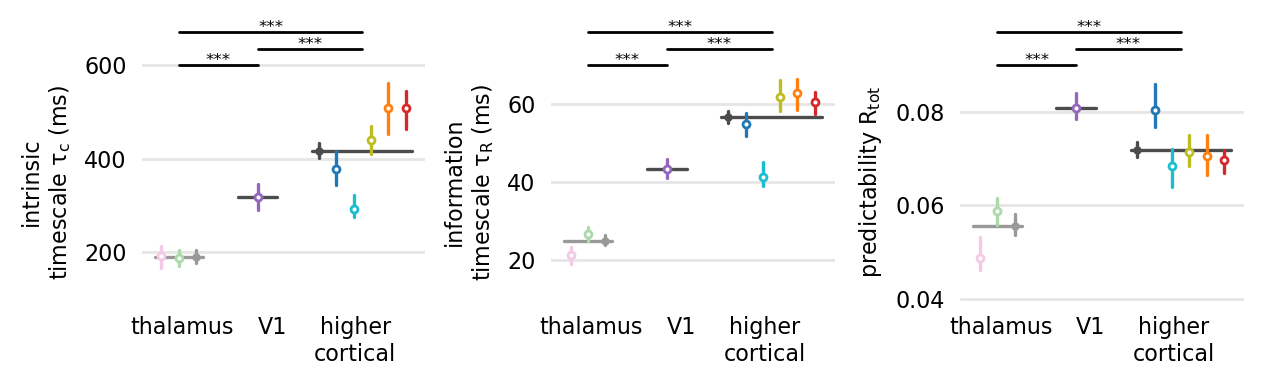

In [165]:


ph.log.setLevel("INFO")
df = meta_df.query("(stimulus == 'natural_movie_one_more_repeats') & (block == '8.0')")
ph.row_structure_groups(df);

# panel_areas_grouped(df, "tau_double")


2023-08-30 12:03:30,232 | INFO     | plot_helper | panel_areas_grouped | grouped tau_double for ['natural_movie_one_more_repeats'] ['3.0'] with 5558 rows
2023-08-30 12:03:30,243 | DEBUG    | plot_helper | panel_areas_grouped | dropping 11 rows with too large timescales
2023-08-30 12:03:30,253 | DEBUG    | plot_helper | panel_areas_grouped | thalamus_grouped has 781 rows
2023-08-30 12:03:30,552 | DEBUG    | plot_helper | panel_areas_grouped | thalamus_grouped median_bs: 0.21, median: 0.21 quantiles: [0.18814899 0.21685848]
2023-08-30 12:03:30,968 | DEBUG    | plot_helper | panel_areas_grouped | dropping 5 rows with too large timescales
2023-08-30 12:03:30,969 | DEBUG    | plot_helper | panel_areas_grouped | V1_grouped has 1032 rows
2023-08-30 12:03:31,242 | DEBUG    | plot_helper | panel_areas_grouped | V1_grouped median_bs: 0.27, median: 0.27 quantiles: [0.24496353 0.28837439]
2023-08-30 12:03:31,514 | DEBUG    | plot_helper | panel_areas_grouped | dropping 42 rows with too large times

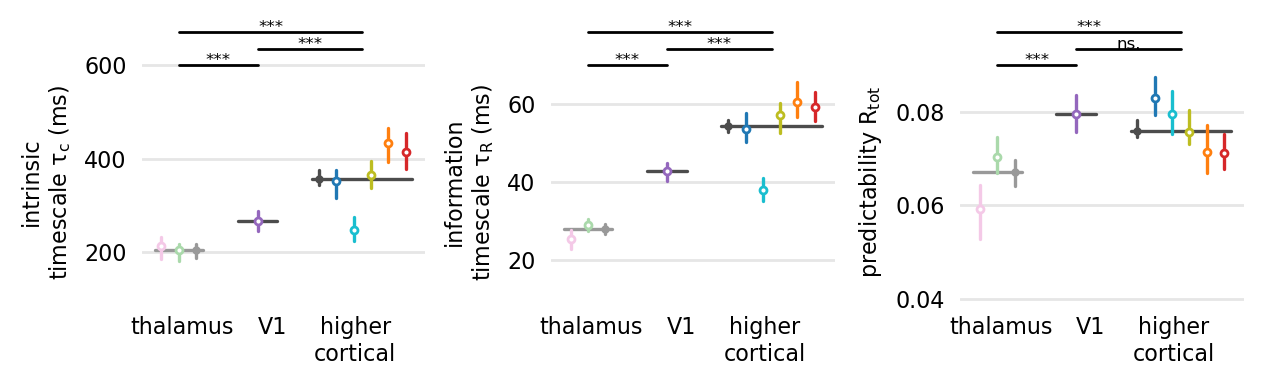

In [166]:
ph.log.setLevel("DEBUG")
df = meta_df.query("(stimulus == 'natural_movie_one_more_repeats') & (block == '3.0')")
df = df.query("R_tot == R_tot")
df = df.query("tau_R == tau_R")
ph.row_structure_groups(df);

2023-08-30 12:02:59,272 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2023-08-30 12:02:59,275 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_double agains hierarchy score for ['natural_movie_one_more_repeats'] ['8.0'] with 5089 rows
2023-08-30 12:03:00,986 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2023-08-30 12:03:00,988 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_R agains hierarchy score for ['natural_movie_one_more_repeats'] ['8.0'] with 5089 rows
2023-08-30 12:03:02,528 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2023-08-30 12:03:02,531 | INFO     | plot_helper | panel_hierarchy_score | plotting R_tot agains hierarchy score for ['natural_movie_one_more_repeats'] ['8.0'] with 5089 rows


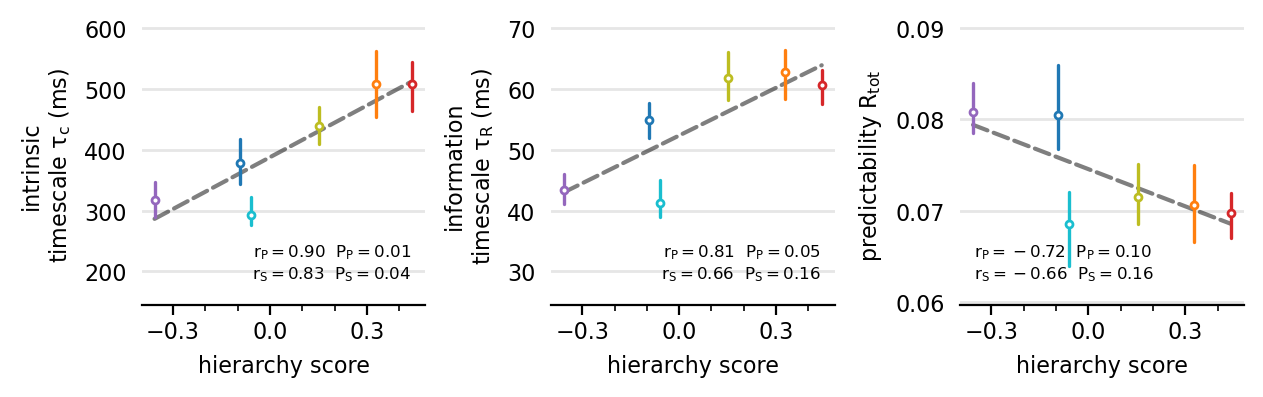

In [164]:

ph.log.setLevel("INFO")
df = meta_df.query("(stimulus == 'natural_movie_one_more_repeats') & (block == '8.0')")
ph.row_hierarchy_score(df);


2023-08-30 12:03:40,061 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2023-08-30 12:03:40,066 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_double agains hierarchy score for ['natural_movie_one_more_repeats'] ['3.0'] with 4767 rows
2023-08-30 12:03:41,577 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2023-08-30 12:03:41,580 | INFO     | plot_helper | panel_hierarchy_score | plotting tau_R agains hierarchy score for ['natural_movie_one_more_repeats'] ['3.0'] with 4767 rows
2023-08-30 12:03:43,105 | INFO     | plot_helper | panel_hierarchy_score | dropping LGN and LP to focus on cortical hierarchy
2023-08-30 12:03:43,107 | INFO     | plot_helper | panel_hierarchy_score | plotting R_tot agains hierarchy score for ['natural_movie_one_more_repeats'] ['3.0'] with 4767 rows


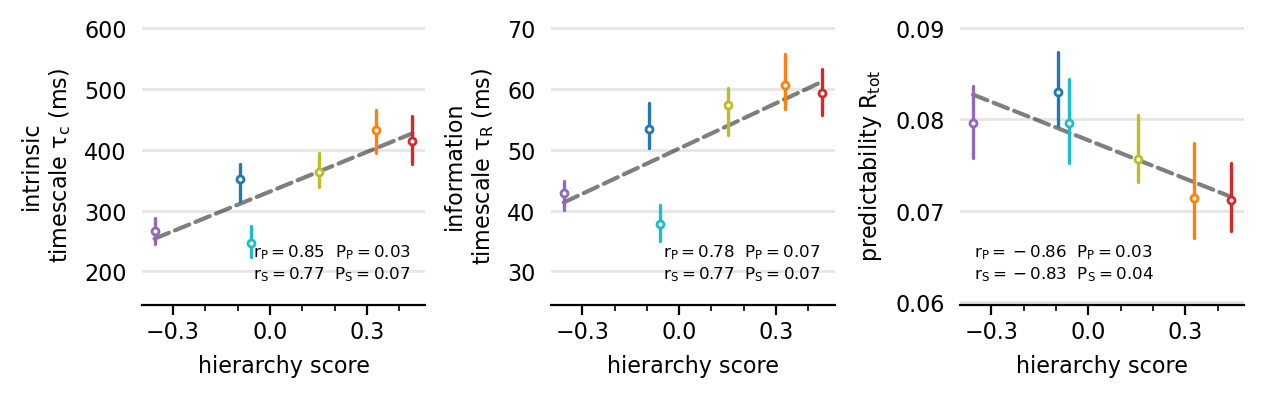

In [167]:
ph.log.setLevel("INFO")
df = meta_df.query("(stimulus == 'natural_movie_one_more_repeats') & (block == '3.0')")
ph.row_hierarchy_score(df);


In [74]:
meta_df

,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,R_tot,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg
0,950987325,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,898.087891,1.999804,/data.nst/share/data/allen_visual_coding_neuro...,1796,...,0.027605,0.306734,2.241440,2.241020,"{'firing_rate': 2.0738371954275348, 'firing_ra...","{'tau': 2.241440355939673, 'mre': 0.9977717777...","{'tau': 2.2410198071730076, 'mre': 0.997771360...",NaN,NaN,NaN
1,950987344,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,898.868408,0.837720,/data.nst/share/data/allen_visual_coding_neuro...,753,...,0.270567,0.012211,0.045573,0.043030,"{'firing_rate': 0.7508380960377098, 'firing_ra...","{'tau': 0.045573393213975646, 'mre': 0.8960911...","{'tau': 0.04303043931112166, 'mre': 0.89029998...",NaN,NaN,NaN
2,950987340,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,900.287354,1.568388,/data.nst/share/data/allen_visual_coding_neuro...,1412,...,0.039402,0.059192,0.280984,0.245722,"{'firing_rate': 1.5801313991442945, 'firing_ra...","{'tau': 0.28098421748789454, 'mre': 0.98236279...","{'tau': 0.24572237330663918, 'mre': 0.97985745...",NaN,NaN,NaN
3,950987352,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,894.181885,0.542395,/data.nst/share/data/allen_visual_coding_neuro...,485,...,0.076247,0.125046,0.673576,0.606872,"{'firing_rate': 0.5503333173468898, 'firing_ra...","{'tau': 0.6735760723849045, 'mre': 0.992604416...","{'tau': 0.6068717836955805, 'mre': 0.991794874...",NaN,NaN,NaN
4,950987362,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,900.613525,2.053045,/data.nst/share/data/allen_visual_coding_neuro...,1849,...,0.032636,0.115843,0.823834,0.742092,"{'firing_rate': 1.8513667968377936, 'firing_ra...","{'tau': 0.8238338588105363, 'mre': 0.993949195...","{'tau': 0.7420923475915008, 'mre': 0.993284941...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30334,951871993,natural_movie_three,746083955,6.0,VISrl,SUCCESS,600.057373,11.000614,/data.nst/share/data/allen_visual_coding_neuro...,6601,...,0.062859,0.009846,0.617059,0.039676,"{'firing_rate': 10.742867728788442, 'firing_ra...","{'tau': 0.6170588395992576, 'mre': 0.991929785...","{'tau': 0.03967567803448679, 'mre': 0.88159563...",0.100972,0.446203,0.297018
30335,951872268,natural_movie_three,746083955,6.0,VISrl,SUCCESS,597.371582,4.288787,/data.nst/share/data/allen_visual_coding_neuro...,2562,...,0.081390,0.030980,0.662368,0.039927,"{'firing_rate': 4.131376659678547, 'firing_rat...","{'tau': 0.6623679065167765, 'mre': 0.992479744...","{'tau': 0.03992727956949193, 'mre': 0.88229601...",0.075939,0.641525,2.461999
30336,951872311,natural_movie_three,746083955,6.0,VISrl,SUCCESS,588.665527,0.482447,/data.nst/share/data/allen_visual_coding_neuro...,284,...,0.121748,0.002582,0.184201,0.157025,"{'firing_rate': 0.4842661914401108, 'firing_ra...","{'tau': 0.1842007216756894, 'mre': 0.973220793...","{'tau': 0.15702518290759573, 'mre': 0.96865959...",0.048739,0.487186,0.407331
30337,951872945,natural_movie_three,746083955,6.0,VISrl,SUCCESS,597.266846,0.502288,/data.nst/share/data/allen_visual_coding_neuro...,300,...,0.105830,0.004683,0.176060,0.098597,"{'firing_rate': 0.48824167020123466, 'firing_r...","{'tau': 0.17606012787198508, 'mre': 0.97200008...","{'tau': 0.0985971458498803, 'mre': 0.950552953...",0.126904,0.803712,1.934723


2023-08-30 12:29:23,009 | DEBUG    | notebook | <module> | dropping 418 rows with too large timescales
2023-08-30 12:29:23,791 | DEBUG    | plot_helper | fancy_violins | 3.0 median: 1.6762 quantiles: [1.66462299 1.6889493 ] from 500 samples of length 5309
2023-08-30 12:29:23,792 | DEBUG    | plot_helper | fancy_violins | 3.0 min: 0.28 max: 3.2
2023-08-30 12:29:24,577 | DEBUG    | plot_helper | fancy_violins | 8.0 median: 1.6856 quantiles: [1.67519623 1.6955268 ] from 500 samples of length 5706
2023-08-30 12:29:24,577 | DEBUG    | plot_helper | fancy_violins | 8.0 min: 0.28 max: 3
2023-08-30 12:29:25,150 | DEBUG    | plot_helper | fancy_violins | null median: 1.7152 quantiles: [1.70334435 1.73405567] from 500 samples of length 5782
2023-08-30 12:29:25,151 | DEBUG    | plot_helper | fancy_violins | null min: 0.28 max: 2.9
2023-08-30 12:29:25,162 | DEBUG    | plot_helper | fancy_violins | plotting 1200 points for cat block


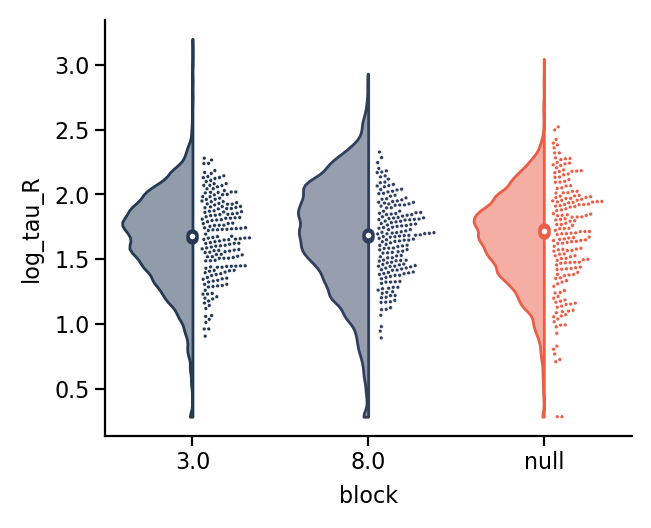

In [204]:
ph.log.setLevel("DEBUG")


df = meta_df.query(
    "((stimulus == 'natural_movie_one_more_repeats') & (block == '3.0')) | " + 
    "((stimulus == 'natural_movie_one_more_repeats') & (block == '8.0')) | "
    + "((stimulus == 'spontaneous') & (block == 'null'))"
)

obs = "tau_R"

df[f"log_{obs}"] = df.apply(lambda row: np.log10(row[obs] * 1000), axis=1)

if "tau" in obs:
    # everything above 10s is unrealistic
    num_dropped = len(df.query(f"({obs} > 10) | ({obs} <= 0)"))
    log.debug(f"dropping {num_dropped} rows with too large timescales")
    df = df.query(f"({obs} <= 1000) & ({obs} > 0.00)")

# this is a paired sample thing, only take units that have both stimuli
# fiund the intersection of units that exist in both stimuli
units = set(
    df.query("stimulus == 'spontaneous'")["unit_id"]
).intersection(set(df.query("stimulus == 'natural_movie_one_more_repeats'")["unit_id"]))
df = df.query("unit_id in @units")

ax = ph.fancy_violins(
    df,
    category="block",
    observable=f"log_{obs}",
    num_swarm_points=400,
    same_points_per_swarm=True,
    seed=44,
    replace=False,
    # palette=dict(natural_movie_one_more_repeats="#233954", spontaneous="#EA5E48"),
    palette={
        "3.0" : "#233954",
        "8.0" : "#2F3F5F",
        "null" : "#EA5E48",
    },  
    violin_kwargs=dict(
        scale="width",
    ),
    swarm_kwargs=dict(
        size=1.4,
    ),
)


2023-08-30 12:23:47,205 | INFO     | notebook | <module> | r: -0.052, p: 4.3e-05, m: -0.024, b: 0.059


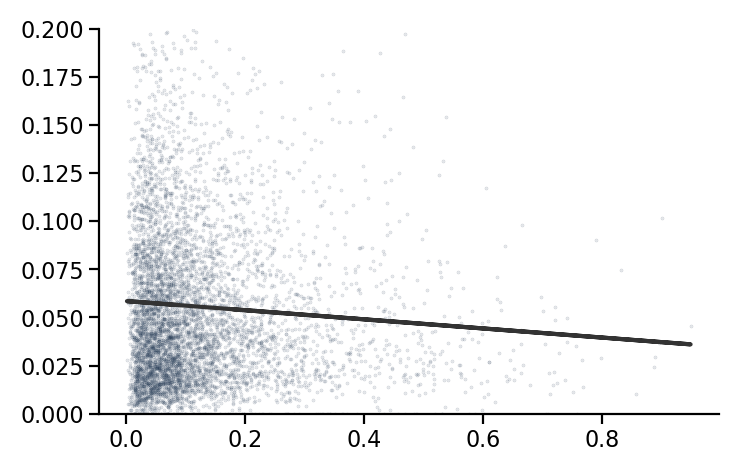

In [198]:
import scipy.stats

df = meta_df.query("stimulus == 'natural_movie_three' & block == '3.0'")
df = df.query("(tau_double <= 10) & (tau_double > 0)")

obs = "tau_R"
df = df.query(f"{obs} == {obs}")
df = df.query("g_dsi_dg == g_dsi_dg")
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.scatter(df["g_dsi_dg"], df[obs], s=0.1, alpha=0.2);
ax.set_ylim(0, 0.2)
# ax.set_xscale("log")

r , p_val = scipy.stats.pearsonr(df["g_dsi_dg"], df[obs])
m, b = np.polyfit(df["g_dsi_dg"], df[obs], 1)

log.info(f"r: {r:.3f}, p: {p_val:.2g}, m: {m:.3f}, b: {b:.3f}")
ax.plot(df["g_dsi_dg"], m*df["g_dsi_dg"] + b, color = ".2")



In [139]:
meta_df

,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,R_tot,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,g_dsi_dg,image_selectivity_ns,mod_idx_dg
0,950987325,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,898.087891,1.999804,/data.nst/share/data/allen_visual_coding_neuro...,1796,...,0.027605,0.306734,2.241440,2.241020,"{'firing_rate': 2.0738371954275348, 'firing_ra...","{'tau': 2.241440355939673, 'mre': 0.9977717777...","{'tau': 2.2410198071730076, 'mre': 0.997771360...",NaN,NaN,NaN
1,950987344,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,898.868408,0.837720,/data.nst/share/data/allen_visual_coding_neuro...,753,...,0.270567,0.012211,0.045573,0.043030,"{'firing_rate': 0.7508380960377098, 'firing_ra...","{'tau': 0.045573393213975646, 'mre': 0.8960911...","{'tau': 0.04303043931112166, 'mre': 0.89029998...",NaN,NaN,NaN
2,950987340,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,900.287354,1.568388,/data.nst/share/data/allen_visual_coding_neuro...,1412,...,0.039402,0.059192,0.280984,0.245722,"{'firing_rate': 1.5801313991442945, 'firing_ra...","{'tau': 0.28098421748789454, 'mre': 0.98236279...","{'tau': 0.24572237330663918, 'mre': 0.97985745...",NaN,NaN,NaN
3,950987352,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,894.181885,0.542395,/data.nst/share/data/allen_visual_coding_neuro...,485,...,0.076247,0.125046,0.673576,0.606872,"{'firing_rate': 0.5503333173468898, 'firing_ra...","{'tau': 0.6735760723849045, 'mre': 0.992604416...","{'tau': 0.6068717836955805, 'mre': 0.991794874...",NaN,NaN,NaN
4,950987362,natural_movie_one_more_repeats,774875821,3.0,VISam,SUCCESS,900.613525,2.053045,/data.nst/share/data/allen_visual_coding_neuro...,1849,...,0.032636,0.115843,0.823834,0.742092,"{'firing_rate': 1.8513667968377936, 'firing_ra...","{'tau': 0.8238338588105363, 'mre': 0.993949195...","{'tau': 0.7420923475915008, 'mre': 0.993284941...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30334,951871993,natural_movie_three,746083955,6.0,VISrl,SUCCESS,600.057373,11.000614,/data.nst/share/data/allen_visual_coding_neuro...,6601,...,0.062859,0.009846,0.617059,0.039676,"{'firing_rate': 10.742867728788442, 'firing_ra...","{'tau': 0.6170588395992576, 'mre': 0.991929785...","{'tau': 0.03967567803448679, 'mre': 0.88159563...",0.100972,0.446203,0.297018
30335,951872268,natural_movie_three,746083955,6.0,VISrl,SUCCESS,597.371582,4.288787,/data.nst/share/data/allen_visual_coding_neuro...,2562,...,0.081390,0.030980,0.662368,0.039927,"{'firing_rate': 4.131376659678547, 'firing_rat...","{'tau': 0.6623679065167765, 'mre': 0.992479744...","{'tau': 0.03992727956949193, 'mre': 0.88229601...",0.075939,0.641525,2.461999
30336,951872311,natural_movie_three,746083955,6.0,VISrl,SUCCESS,588.665527,0.482447,/data.nst/share/data/allen_visual_coding_neuro...,284,...,0.121748,0.002582,0.184201,0.157025,"{'firing_rate': 0.4842661914401108, 'firing_ra...","{'tau': 0.1842007216756894, 'mre': 0.973220793...","{'tau': 0.15702518290759573, 'mre': 0.96865959...",0.048739,0.487186,0.407331
30337,951872945,natural_movie_three,746083955,6.0,VISrl,SUCCESS,597.266846,0.502288,/data.nst/share/data/allen_visual_coding_neuro...,300,...,0.105830,0.004683,0.176060,0.098597,"{'firing_rate': 0.48824167020123466, 'firing_r...","{'tau': 0.17606012787198508, 'mre': 0.97200008...","{'tau': 0.0985971458498803, 'mre': 0.950552953...",0.126904,0.803712,1.934723
